# NLP_Project_Exercise

**Business objective -** The document classification solution should significantly reduce the manual human effort in the HRM and financial department. It should achieve a higher level of accuracy and automation with minimal human intervention.

**Sample Data Set Details:** Resumes and financial documents.

### Import libaries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 

# for text_pre-processing
import sys
import unicodedata
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

# for bag_of_words
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer

# for model_building
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, precision_score, f1_score, recall_score, plot_confusion_matrix


import warnings
warnings.filterwarnings('ignore')

### Import dataset

In [2]:
df = pd.read_csv('Text.csv', encoding='utf-8')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,Names,Profiles,Summary
0,Krishna_Kanth,Developer resumes,Ui-Developer/ React JS Developer \n\nNAME: KRI...
1,Naveen sadhu,Developer resumes,Naveen Sadhu\n\n\n\n\n\nTitle: software develo...
2,Pragnya,Developer resumes,PRAGNYA PATTNAIK\n\n \n\n \n\n \n\n Expertise:...
3,Thirupathiamma,Developer resumes,Thirupathamma Balla\n\n\n\nSUMMARY:\n\n\n\n2.8...
4,Haripriya,Developer resumes,HARIPRIYA BATTINA \n\nExperience as UI Develop...


In [3]:
df.tail()

,Names,Profiles,Summary
74,Arun Venu,Peoplesoft resumes,\nArun Venu\n\n\n EXPERIENCE SUMMARY\n\n\n ...
75,Pritam Biswas,Peoplesoft resumes,\n|Personal Details ...
76,Rahul Ahuja,Peoplesoft resumes,\nRahul Ahuja\n-------------------------------...
77,Varkala Vikas,Peoplesoft resumes,PeopleSoft Admin\n\nVARKALA VIKAS\n\n\n\nCaree...
78,Subha Santosh,Peoplesoft resumes,C O N T A C T :\n\n\n\nAddress: Manyata Tech P...


### EDA | Data Preprocessing

In [4]:
df.shape

(79, 3)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79 entries, 0 to 78
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Names     79 non-null     object
 1   Profiles  79 non-null     object
 2   Summary   79 non-null     object
dtypes: object(3)
memory usage: 2.0+ KB


In [6]:
df.duplicated(subset=None, keep='first')

0     False
1     False
2     False
3     False
4     False
      ...  
74    False
75    False
76    False
77    False
78    False
Length: 79, dtype: bool

In [7]:
df.drop_duplicates(inplace=True)

#### Removing Unwanted Character's

In [8]:
# Data Cleaning.
# Dictionary of Punctuation marks.
keys = [i for i in range(sys.maxunicode) if unicodedata.category(chr(i)).startswith('P')]
punctuation = dict.fromkeys(keys,' ')
# Dictionary of new_line '\n' and '\t'.
new_line_tab = str.maketrans({chr(10):' ',chr(9):' '})

In [9]:
def preprocessor(text):
    text = re.sub('\n',' ',text)  # remove new lines.
    text = re.sub('\t',' ',text)  # remove tabs.
    text = re.sub('❖',' ',text) 
    text = re.sub('@[A-Za-z0-9]+',' ',text) # remove tags(@).
    text = re.sub('#',' ',text)   # remove hashtag(#).
    #text = re.sub('https?:\/\/\S+', ' ', text) # Removing links
    text = re.sub(r'http\S+',' ',text)  # remove https links.
    text = re.sub(':',' ',text)   # remove tabs.
    text = re.sub('<[^<]+?>',' ',text)  # remove html tags.
    text = re.sub(r'[^\w]',' ',text)   # remove non alphanumeric characters.
    #text = re.sub('httpS+s*', ' ', text)  # remove URLs
    #text = re.sub('RT|cc', ' ', text)  # remove RT and cc
    #text = re.sub('#S+', '', text)  # remove hashtags
    #text = re.sub('@S+', '  ', text)  # remove mentions
    #text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[]^_`{|}~"""), ' ', text)  # remove punctuations
    #text = re.sub('s+',' ',text)  # remove extra whitespace.
    
    text = text.translate(punctuation)
    text = text.lower()
    text = text.strip()
    text = text.translate(new_line_tab)
    return text

df['Summary'] = df['Summary'].apply(lambda x: preprocessor(x))
df.head()

,Names,Profiles,Summary
0,Krishna_Kanth,Developer resumes,ui developer react js developer name krish...
1,Naveen sadhu,Developer resumes,naveen sadhu title software developer ...
2,Pragnya,Developer resumes,pragnya pattnaik expertise ha...
3,Thirupathiamma,Developer resumes,thirupathamma balla summary 2 8 year of...
4,Haripriya,Developer resumes,haripriya battina experience as ui developer...


In [10]:
df.Profiles.value_counts()

workday resumes                    21
Peoplesoft resumes                 20
SQL Developer Lightning insight    14
Developer resumes                  11
JS Developer resumes               11
Internship resumes                  2
Name: Profiles, dtype: int64

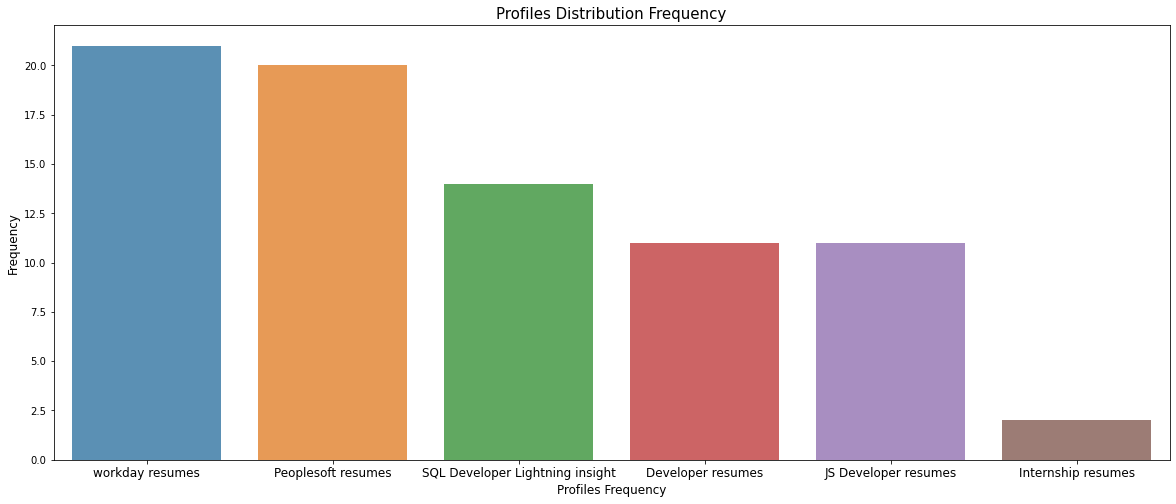

In [11]:
# Using bar_plot for Profiles Distribution Frequency.
x_rating = df.Profiles.value_counts()
y_rating = x_rating.sort_index()
plt.figure(figsize=(20,8))
sns.barplot(x_rating.index, x_rating.values, alpha=0.8,)
plt.title('Profiles Distribution Frequency', fontsize=15)
plt.ylabel('Frequency', fontsize=12)
plt.yticks(fontsize=10)
plt.xlabel('Profiles Frequency', fontsize=12)
plt.xticks(fontsize=12)
plt.show()

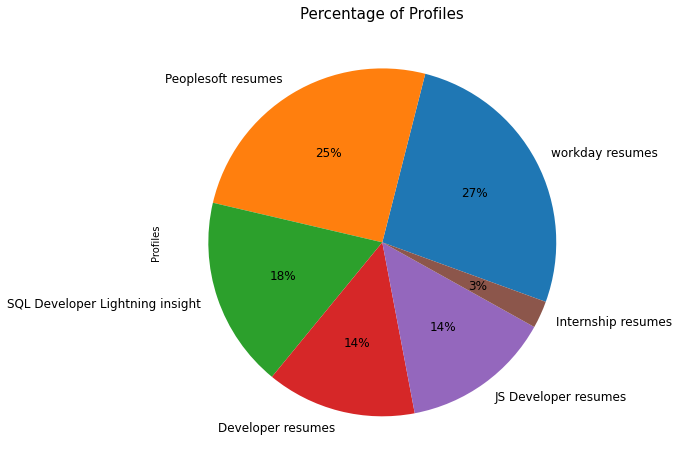

In [12]:
# Using Pie_Chart for Percentage of Profiles.
plt.figure(figsize=(10,8))
plt.title('Percentage of Profiles', fontsize=15)
df['Profiles'].value_counts().plot(kind='pie', 
                                labels=['workday resumes', 
                                      'Peoplesoft resumes', 
                                      'SQL Developer Lightning insight', 
                                      'Developer resumes', 
                                      'JS Developer resumes',
                                      'Internship resumes'],
                                autopct='%1.0f%%', 
                                startangle= -20, 
                                textprops={'fontsize': 12})
plt.show()

#### Word Tokenization

In [13]:
# Word Tokenization.
# Getting the entire Resumes text.
corpus = ' ';
for i in range(0, len(df)):
    corpus = corpus + df['Summary'][i]

In [14]:
# Removing extra whitespaces in corpus.
corpus = re.sub(' + ',' ',corpus) 
corpus[500:2000]

'se in analyzing the document object model dom layout dom functions and java script functions cascading styles across cross browser using fire bug developer tool bar expertise in react js framework to develop the spa experienced in react js and working with react flux architecture experienced in working with redux architecture using complex object oriented concepts in improving the performance of the websites experience in using react js components forms events keys router plus redux animations expertise in video coding by using html5 css3 and javascript expertise in restful soap web services to integrate between application to application experience with front end development with back end system integration technical skills web technologies html css3 xml javascript json react js node js github qualification b tech from jntu kakinada university 2016 professional experience i have experience as react js developer with 3 2 years of experience in the it industry and currently working in 

In [15]:
tokens = word_tokenize(corpus)
len(tokens)

57664

In [16]:
# Now we shall make everything lowercase for uniformity.
# To hold the new lower case words.
words = []
# Looping through the tokens and make then lower case.
for word in tokens:
    words.append(word.lower())

#### Removing Stopwords

In [17]:
# Stopwords are generally the most commonn words in a language.
# English stopwords from nltk.
stopwords = nltk.corpus.stopwords.words('english')
words_new = []
# Now we need to remove the stopwords from the words variable.
# Appending to words_new all words that are in words but not in sw.
for word in words:
    if word not in stopwords:
        words_new.append(word)

In [18]:
len(words_new)

44035

In [19]:
wn = WordNetLemmatizer()
lema_words = []
for word in words_new:
    word = wn.lemmatize(word)
    lema_words.append(word)

In [20]:
len(lema_words)

44035

In [21]:
# How many tokens has been converted into lemmtized words.
same = 0
diff = 0

for i in range (0, len(words_new)):
    if (words_new[i] == lema_words[i]):
        same = same + 1;
    elif (words_new[i] != lema_words[i]):
        diff = diff + 1;
print('Number of words that are lemmitized :', diff)
print('Number of words that are not lemmitized are :', same)

Number of words that are lemmitized : 6991
Number of words that are not lemmitized are : 37044


#### Word Cloud and Frequency Plot

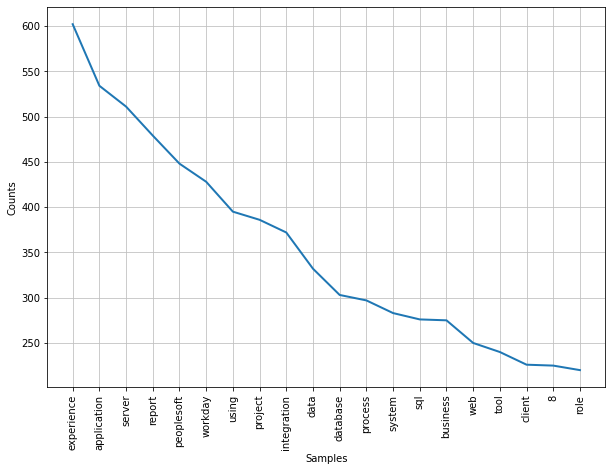

In [22]:
# Word cloud Vs the Frequency plot.
# The frequency distribution of lema_words.
# frequency distribution plots.
freq_disk = nltk.FreqDist(lema_words)
plt.subplots(figsize=(10,7))
freq_disk.plot(20)
plt.show()

In [23]:
# Frequency distribution of lema_words.
most_common_word = freq_disk.most_common(20)
most_common_word

[('experience', 602),
 ('application', 534),
 ('server', 511),
 ('report', 479),
 ('peoplesoft', 448),
 ('workday', 428),
 ('using', 395),
 ('project', 386),
 ('integration', 372),
 ('data', 332),
 ('database', 303),
 ('process', 297),
 ('system', 283),
 ('sql', 276),
 ('business', 275),
 ('web', 250),
 ('tool', 240),
 ('client', 226),
 ('8', 225),
 ('role', 220)]

In [24]:
# Let’s convert the list into a string.
df['Extract_Text'] = [' '.join(map(str,l)) for l in df['Summary']]
df.head()

,Names,Profiles,Summary,Extract_Text
0,Krishna_Kanth,Developer resumes,ui developer react js developer name krish...,u i d e v e l o p e r r e a c t j s ...
1,Naveen sadhu,Developer resumes,naveen sadhu title software developer ...,n a v e e n s a d h u t i t l e ...
2,Pragnya,Developer resumes,pragnya pattnaik expertise ha...,p r a g n y a p a t t n a i k ...
3,Thirupathiamma,Developer resumes,thirupathamma balla summary 2 8 year of...,t h i r u p a t h a m m a b a l l a ...
4,Haripriya,Developer resumes,haripriya battina experience as ui developer...,h a r i p r i y a b a t t i n a e x p ...


In [25]:
# Let’s create two additional features of “word_count”.
df['word_count'] = df['Summary'].apply(lambda x: len(str(x).split()))
df['review_len'] = df['Extract_Text'].astype(str).apply(len)
df.head()

,Names,Profiles,Summary,Extract_Text,word_count,review_len
0,Krishna_Kanth,Developer resumes,ui developer react js developer name krish...,u i d e v e l o p e r r e a c t j s ...,537,7401
1,Naveen sadhu,Developer resumes,naveen sadhu title software developer ...,n a v e e n s a d h u t i t l e ...,227,3575
2,Pragnya,Developer resumes,pragnya pattnaik expertise ha...,p r a g n y a p a t t n a i k ...,403,6213
3,Thirupathiamma,Developer resumes,thirupathamma balla summary 2 8 year of...,t h i r u p a t h a m m a b a l l a ...,244,3847
4,Haripriya,Developer resumes,haripriya battina experience as ui developer...,h a r i p r i y a b a t t i n a e x p ...,383,5327


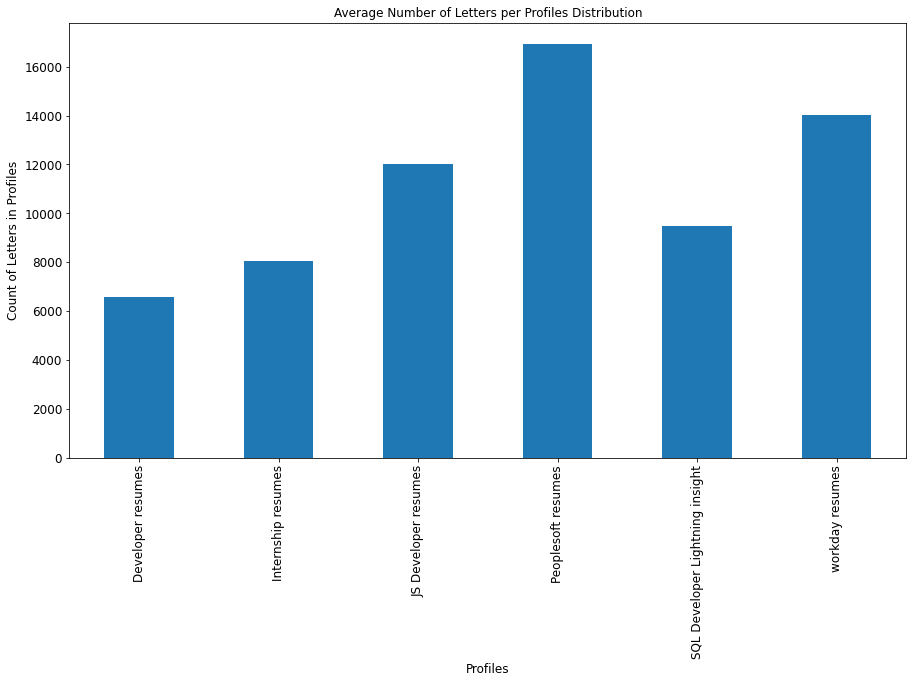

In [26]:
# Using barplot for 'review_len' to letter frequency analysis for profiles Distribution.
letter_avg = df.groupby('Profiles')['review_len'].mean().plot(kind='bar', figsize=(15,8))
plt.xlabel('Profiles', fontsize=12)
plt.ylabel('Count of Letters in Profiles', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Average Number of Letters per Profiles Distribution', fontsize=12)
plt.show()

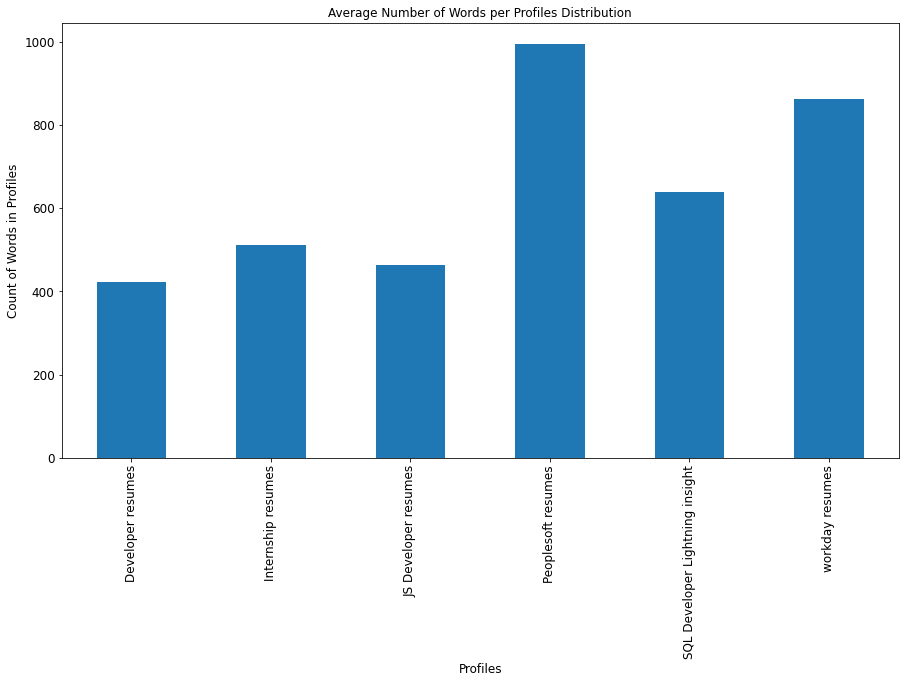

In [27]:
# Using barplot for 'word_count' to words frequency analysis for profiles Distribution.
word_avg = df.groupby('Profiles')['word_count'].mean().plot(kind='bar', figsize=(15,8))
plt.xlabel('Profiles', fontsize=12)
plt.ylabel('Count of Words in Profiles', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Average Number of Words per Profiles Distribution', fontsize=12)
plt.show()

#### Generate Word_Cloud

In [28]:
words = df['Summary']
allwords = []
for wordlist in words:
    allwords.append(wordlist)

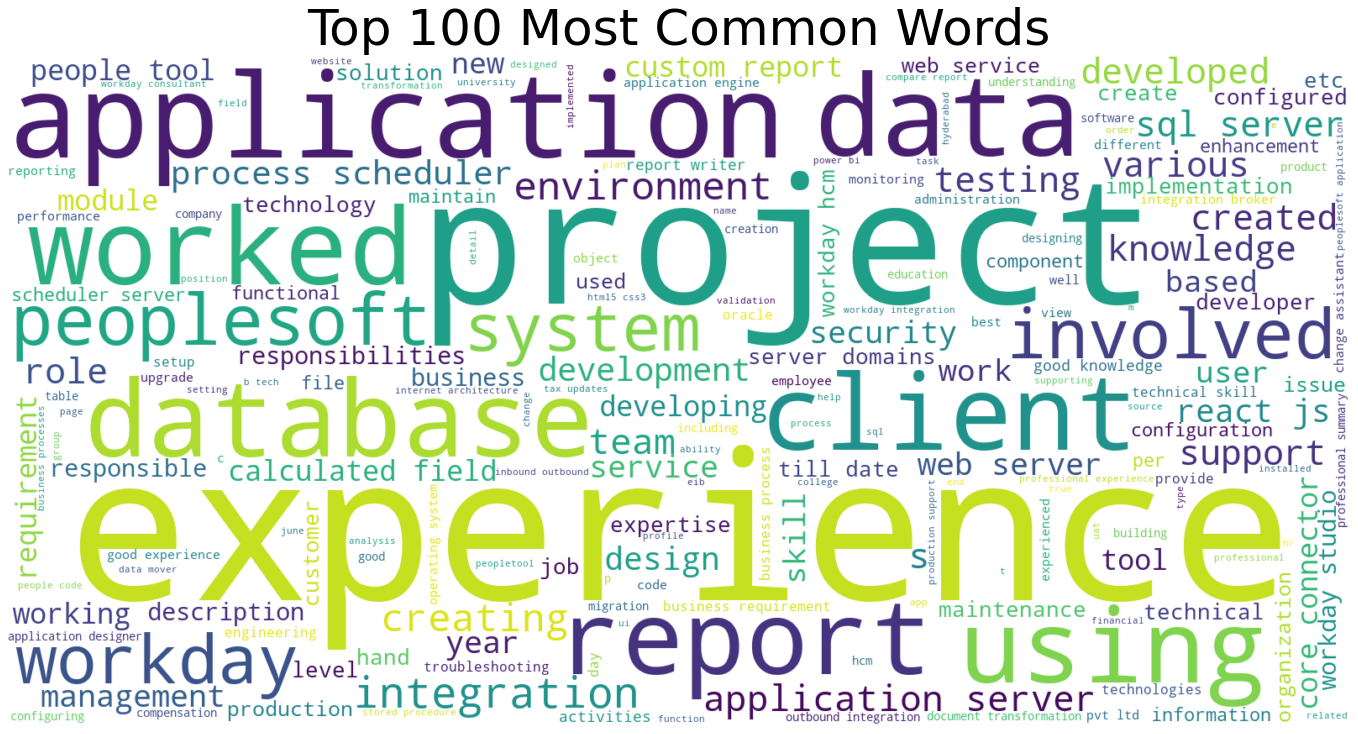

In [29]:
# Generate word_cloud for most common word.
mostcommon = nltk.FreqDist(allwords).most_common(100)

wordcloud = WordCloud(width=1600, height=800, background_color='white').generate(str(mostcommon))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=50)
plt.tight_layout(pad=0)
plt.show()

### Model Building | Model Training | Model Testing

In [30]:
# Split the data X amd y.
X = df.Summary
y = df.Profiles

# Using the train_test_split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42, shuffle=True)

#### Logistic_Regression

In [31]:
# Using Logistic_Regression, CountVectorizer and TF-IDF Transformer to build the Model.
lr_model = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5))])

# Fit the LR_Model.
lr_model.fit(X_train, y_train)

# Predicting the LR_Model.
lr_pred_train = lr_model.predict(X_train)
lr_pred_test = lr_model.predict(X_test)

In [32]:
# Evaluating the LR_Model_Training.
# Training_Score.
print('LR_Model Training Score : \n')

lr_model_train_acc = accuracy_score(y_train, lr_pred_train)
print('Accuracy_Score  : {:.3f}'.format(lr_model_train_acc))

lr_model_train_pre = precision_score(y_train, lr_pred_train, average='weighted')
print('Precision_Score : {:.3f}'.format(lr_model_train_pre))

lr_model_train_f1 = f1_score(y_train, lr_pred_train, average='weighted')
print('F1_Score        : {:.3f}'.format(lr_model_train_f1))

lr_model_train_re = recall_score(y_train, lr_pred_train, average='weighted')
print('Recall_Score    : {:.3f}'.format(lr_model_train_re))

LR_Model Training Score : 

Accuracy_Score  : 1.000
Precision_Score : 1.000
F1_Score        : 1.000
Recall_Score    : 1.000


In [33]:
# Evaluating the LR_Model_Testing.
# Testing_Score.
print('LR_Model Testing Score : \n')

lr_model_test_acc = accuracy_score(y_test, lr_pred_test)
print('Accuracy_Score  : {:.3f}'.format(lr_model_test_acc))

lr_model_test_pre = precision_score(y_test, lr_pred_test, average='weighted')
print('Precision_Score : {:.3f}'.format(lr_model_test_pre))

lr_model_test_f1 = f1_score(y_test, lr_pred_test, average='weighted')
print('F1_Score        : {:.3f}'.format(lr_model_test_f1))

lr_model_test_re = recall_score(y_test, lr_pred_test, average='weighted')
print('Recall_Score    : {:.3f}'.format(lr_model_test_re))

LR_Model Testing Score : 

Accuracy_Score  : 0.792
Precision_Score : 0.822
F1_Score        : 0.795
Recall_Score    : 0.792


In [34]:
# Conclusion of the Lr_result.
score = ['Accuracy_Score','Precision_Score','Recall_Score','F1_Score']
train = [lr_model_train_acc, lr_model_train_pre, lr_model_train_re, lr_model_train_f1]
test = [lr_model_test_acc, lr_model_test_pre, lr_model_test_re, lr_model_test_f1]

lr_result = pd.DataFrame({'LR_Model_Score':score,'Train_Accuracy':train,'Test_Accuracy':test}).round(3)
lr_result.reindex()

,LR_Model_Score,Train_Accuracy,Test_Accuracy
0,Accuracy_Score,1.0,0.792
1,Precision_Score,1.0,0.822
2,Recall_Score,1.0,0.792
3,F1_Score,1.0,0.795


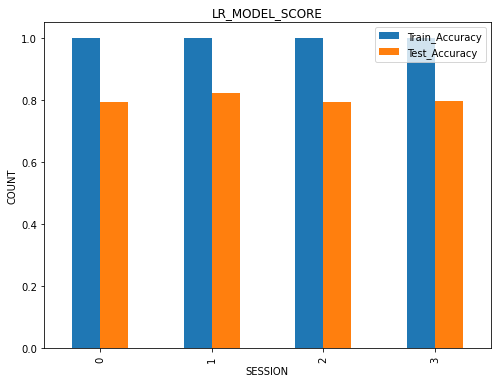

In [35]:
# Using bar-plot for conclusion of the lr_result.
lr_result[['Train_Accuracy','Test_Accuracy']].plot(kind='bar', figsize=(8,6))
plt.xlabel('SESSION')
plt.ylabel('COUNT')
plt.title('LR_MODEL_SCORE')
plt.legend()
plt.show()

#### MultinomialNB

In [36]:
# Using MultinomialNB, CountVectorizer and TF-IDF Transformer to build the Model.
mnb_model = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', MultinomialNB())])

# Fit the NB_Model.
mnb_model.fit(X_train, y_train)

# Predicting the NB_Model.
mnb_pred_train = mnb_model.predict(X_train)
mnb_pred_test = mnb_model.predict(X_test)

In [37]:
# Evaluating the MNB_Model_Training.
# Training_Score.
print('MNB_Model Training Score : \n')

mnb_model_train_acc = accuracy_score(y_train, mnb_pred_train)
print('Accuracy_Score  : {:.3f}'.format(mnb_model_train_acc))

mnb_model_train_pre = precision_score(y_train, mnb_pred_train, average='weighted')
print('Precision_Score : {:.3f}'.format(mnb_model_train_pre))

mnb_model_train_f1 = f1_score(y_train, mnb_pred_train, average='weighted')
print('F1_Score        : {:.3f}'.format(mnb_model_train_f1))

mnb_model_train_re = recall_score(y_train, mnb_pred_train, average='weighted')
print('Recall_Score    : {:.3f}'.format(mnb_model_train_re))

MNB_Model Training Score : 

Accuracy_Score  : 0.855
Precision_Score : 0.770
F1_Score        : 0.803
Recall_Score    : 0.855


In [38]:
# Evaluating the MNB_Model_Testing.
# Testing_Score.
print('MNB_Model Testing Score : \n')

mnb_model_test_acc = accuracy_score(y_test, mnb_pred_test)
print('Accuracy_Score  : {:.3f}'.format(mnb_model_test_acc))

mnb_model_test_pre = precision_score(y_test, mnb_pred_test, average='weighted')
print('Precision_Score : {:.3f}'.format(mnb_model_test_pre))

mnb_model_test_f1 = f1_score(y_test, mnb_pred_test, average='weighted')
print('F1_Score        : {:.3f}'.format(mnb_model_test_f1))

mnb_model_test_re = recall_score(y_test, mnb_pred_test, average='weighted')
print('Recall_Score    : {:.3f}'.format(mnb_model_test_re))

MNB_Model Testing Score : 

Accuracy_Score  : 0.542
Precision_Score : 0.510
F1_Score        : 0.475
Recall_Score    : 0.542


In [39]:
# Conclusion of the mnb_result.
score = ['Accuracy_Score','Precision_Score','Recall_Score','F1_Score']
train = [mnb_model_train_acc, mnb_model_train_pre, mnb_model_train_re, mnb_model_train_f1]
test = [mnb_model_test_acc, mnb_model_test_pre, mnb_model_test_re, mnb_model_test_f1]

mnb_result = pd.DataFrame({'MNB_Model_Score':score, 'Train_Accuracy':train, 'Test_Accuracy':test}).round(3)
mnb_result.reindex()

,MNB_Model_Score,Train_Accuracy,Test_Accuracy
0,Accuracy_Score,0.855,0.542
1,Precision_Score,0.770,0.510
2,Recall_Score,0.855,0.542
3,F1_Score,0.803,0.475


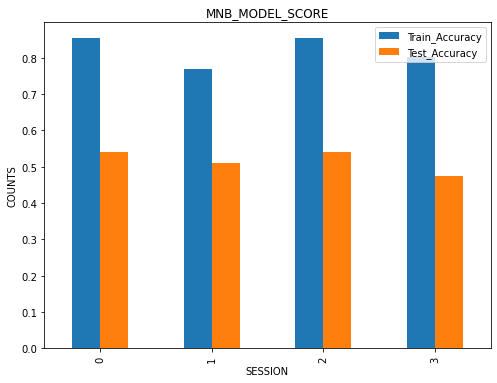

In [40]:
# Using bar-plot for conclusion of the mnb_result.
mnb_result[['Train_Accuracy','Test_Accuracy']].plot(kind='bar', figsize=(8,6))
plt.xlabel('SESSION')
plt.ylabel('COUNTS')
plt.title('MNB_MODEL_SCORE')
plt.legend()
plt.show()

#### Stochastic_Gradient_Descent_Classifier

In [41]:
# Using the SGD_Classifier, CountVectorizer and TF-IDF Transformer to build the Model.
sgd_model = Pipeline([('vect', CountVectorizer()),
                      ('tfidf', TfidfTransformer()),
                      ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None))])

# Fit the SGD_Model.
sgd_model.fit(X_train, y_train)

# Predicting the SGD_Model.
sgd_pred_train = sgd_model.predict(X_train)
sgd_pred_test = sgd_model.predict(X_test)

In [42]:
# Evaluating the SGD_Model_Training.
# Training_Score
print('SGD_Model Training Score : \n')

sgd_model_train_acc = accuracy_score(y_train, sgd_pred_train)
print('Accuracy_Score  : {:.3f}'.format(sgd_model_train_acc))

sgd_model_train_pre = precision_score(y_train, sgd_pred_train, average='weighted')
print('Precision_Score : {:.3f}'.format(sgd_model_train_pre))

sgd_model_train_f1 = f1_score(y_train, sgd_pred_train, average='weighted')
print('F1_Score        : {:.3f}'.format(sgd_model_train_f1))

sgd_model_train_re = recall_score(y_train, sgd_pred_train, average='weighted')
print('Recall_Score    : {:.3f}'.format(sgd_model_train_re))

SGD_Model Training Score : 

Accuracy_Score  : 1.000
Precision_Score : 1.000
F1_Score        : 1.000
Recall_Score    : 1.000


In [43]:
# Evaluating the SGD_Model_Testing.
# Testing_Score.
print('SGD_Model Testing Score : \n')

sgd_model_test_acc = accuracy_score(y_test, sgd_pred_test)
print('Accuracy_Score  : {:.3f}'.format(sgd_model_test_acc))

sgd_model_test_pre = precision_score(y_test, sgd_pred_test, average='weighted')
print('Precision_Score : {:.3f}'.format(sgd_model_test_pre))

sgd_model_test_f1 = f1_score(y_test, sgd_pred_test, average='weighted')
print('F1_Score        : {:.3f}'.format(sgd_model_test_f1))

sgd_model_test_re = recall_score(y_test, sgd_pred_test, average='weighted')
print('Recall_Score    : {:.3f}'.format(sgd_model_test_re))

SGD_Model Testing Score : 

Accuracy_Score  : 0.917
Precision_Score : 0.882
F1_Score        : 0.898
Recall_Score    : 0.917


In [44]:
# Conclusion of the sgd_result.
score = ['Accuracy_Score','Precision_Score','Recall_Score','F1_Score']
train = [sgd_model_train_acc, sgd_model_train_pre, sgd_model_train_re, sgd_model_train_f1]
test = [sgd_model_test_acc, sgd_model_test_pre, sgd_model_test_re, sgd_model_test_f1]

sgd_result = pd.DataFrame({'SGD_Model_Score':score,'Train_Accuracy':train,'Test_Accuracy':test}).round(3)
sgd_result.reindex()

,SGD_Model_Score,Train_Accuracy,Test_Accuracy
0,Accuracy_Score,1.0,0.917
1,Precision_Score,1.0,0.882
2,Recall_Score,1.0,0.917
3,F1_Score,1.0,0.898


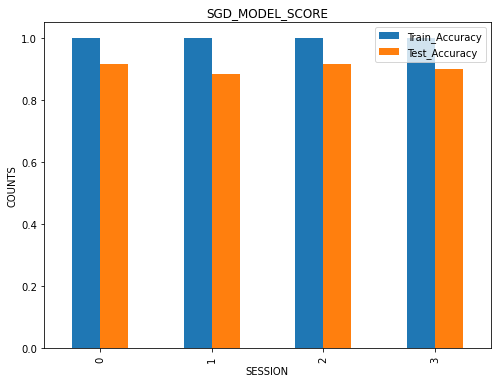

In [45]:
# Using bar-plot for conclusion of the sgd_model_accuracy.
sgd_result[['Train_Accuracy','Test_Accuracy']].plot(kind='bar', figsize=(8,6))
plt.xlabel('SESSION')
plt.ylabel('COUNTS')
plt.title('SGD_MODEL_SCORE')
plt.legend()
plt.show()

#### Decision_Tree_Classifier

In [46]:
# Using DT_Classifier, CountVectorizer and TF-IDF Transformer to build the Model.
dt_model = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', DecisionTreeClassifier(random_state=42, max_depth=6))])

# Fit the DT_Model.
dt_model.fit(X_train, y_train)

# Predicting the DT_Model.
dt_pred_train = dt_model.predict(X_train)
dt_pred_test = dt_model.predict(X_test)

In [47]:
# Evaluating the DT_Model_Training.
# Training_Score.
print('DT_Model Training Score : \n')

dt_model_train_acc = accuracy_score(y_train, dt_pred_train)
print('Accuracy_Score  : {:.3f}'.format(dt_model_train_acc))

dt_model_train_pre = precision_score(y_train, dt_pred_train, average='weighted')
print('Precision_Score : {:.3f}'.format(dt_model_train_pre))

dt_model_train_f1 = f1_score(y_train, dt_pred_train, average='weighted')
print('F1_Score        : {:.3f}'.format(dt_model_train_f1))

dt_model_train_re = recall_score(y_train, dt_pred_train, average='weighted')
print('Recall_Score    : {:.3f}'.format(dt_model_train_re))

DT_Model Training Score : 

Accuracy_Score  : 1.000
Precision_Score : 1.000
F1_Score        : 1.000
Recall_Score    : 1.000


In [48]:
# Evaluating the DT_Model_Testing.
# Testing_Score.
print('DT_Model Testing Score : \n')

dt_model_test_acc = accuracy_score(y_test, dt_pred_test)
print('Accuracy_Score  : {:.3f}'.format(dt_model_test_acc))

dt_model_test_pre = precision_score(y_test, dt_pred_test, average='weighted')
print('Precision_Score : {:.3f}'.format(dt_model_test_pre))

dt_model_test_f1 = f1_score(y_test, dt_pred_test, average='weighted')
print('F1_Score        : {:.3f}'.format(dt_model_test_f1))

dt_model_test_re = recall_score(y_test, dt_pred_test, average='weighted')
print('Recall_Score    : {:.3f}'.format(dt_model_test_re))

DT_Model Testing Score : 

Accuracy_Score  : 0.792
Precision_Score : 0.792
F1_Score        : 0.787
Recall_Score    : 0.792


In [49]:
# Conclusion of the dt_result.
score = ['Accuracy_Score','Precision_Score','Recall_Score','F1_Score']
train = [dt_model_train_acc, dt_model_train_pre, dt_model_train_re, dt_model_train_f1]
test = [dt_model_test_acc, dt_model_test_pre, dt_model_test_re, dt_model_test_f1]

dt_result = pd.DataFrame({'DT_Model_Score':score,'Train_Accuracy':train,'Test_Accuracy':test}).round(3)
dt_result.reindex()

,DT_Model_Score,Train_Accuracy,Test_Accuracy
0,Accuracy_Score,1.0,0.792
1,Precision_Score,1.0,0.792
2,Recall_Score,1.0,0.792
3,F1_Score,1.0,0.787


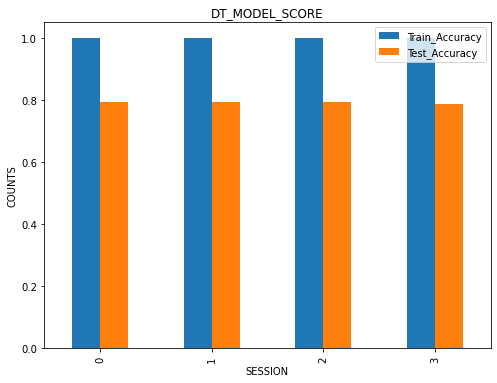

In [50]:
# Using bar-plot for conclusion of the dt_result.
dt_result[['Train_Accuracy','Test_Accuracy']].plot(kind='bar', figsize=(8,6))
plt.xlabel('SESSION')
plt.ylabel('COUNTS')
plt.title('DT_MODEL_SCORE')
plt.legend()
plt.show()

#### Random_Forest_Classifier

In [51]:
# Using RF_Classifier, CountVectorizer and TF-IDF Transformer to build the Model.
rf_model = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(random_state=42, n_estimators=100, max_depth=6))])

# Fit the RF_Model.
rf_model.fit(X_train, y_train)

# Predicting the RF_Model.
rf_pred_train = rf_model.predict(X_train)
rf_pred_test = rf_model.predict(X_test)

In [52]:
# Evaluating the RF_Model_Training.
# Training_Score.
print('RF_Model Training Score : \n')

rf_model_train_acc = accuracy_score(y_train, rf_pred_train)
print('Accuracy_Score  : {:.3f}'.format(rf_model_train_acc))

rf_model_train_pre = precision_score(y_train, rf_pred_train, average='weighted')
print('Precision_Score : {:.3f}'.format(rf_model_train_pre))

rf_model_train_f1 = f1_score(y_train, rf_pred_train, average='weighted')
print('F1_Score        : {:.3f}'.format(rf_model_train_f1))

rf_model_train_re = recall_score(y_train, rf_pred_train, average='weighted')
print('Recall_Score    : {:.3f}'.format(rf_model_train_re))

RF_Model Training Score : 

Accuracy_Score  : 1.000
Precision_Score : 1.000
F1_Score        : 1.000
Recall_Score    : 1.000


In [53]:
# Evaluating the RF_Model_Testing.
# Testing_Score.
print('RF_Model Testing Score : \n')

rf_model_test_acc = accuracy_score(y_test, rf_pred_test)
print('Accuracy_Score  : {:.3f}'.format(rf_model_test_acc))

rf_model_test_pre = precision_score(y_test, rf_pred_test, average='weighted')
print('Precision_Score : {:.3f}'.format(rf_model_test_pre))

rf_model_test_f1 = f1_score(y_test, rf_pred_test, average='weighted')
print('F1_Score        : {:.3f}'.format(rf_model_test_f1))

rf_model_test_re = recall_score(y_test, rf_pred_test, average='weighted')
print('Recall_Score    : {:.3f}'.format(rf_model_test_re))

RF_Model Testing Score : 

Accuracy_Score  : 0.792
Precision_Score : 0.899
F1_Score        : 0.773
Recall_Score    : 0.792


In [54]:
# Conclusion of the rf_result.
score = ['Accuracy_Score','Precision_Score','Recall_Score','F1_Score']
train = [rf_model_train_acc, rf_model_train_pre, rf_model_train_re, rf_model_train_f1]
test = [rf_model_test_acc, rf_model_test_pre, rf_model_test_re, rf_model_test_f1]

rf_result = pd.DataFrame({'RF_Model_Score':score,'Train_Accuracy':train,'Test_Accuracy':test}).round(3)
rf_result.reindex()

,RF_Model_Score,Train_Accuracy,Test_Accuracy
0,Accuracy_Score,1.0,0.792
1,Precision_Score,1.0,0.899
2,Recall_Score,1.0,0.792
3,F1_Score,1.0,0.773


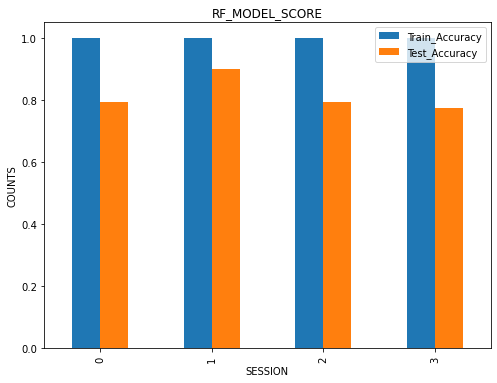

In [55]:
# Using bar-plot for conclusion of the rf_result.
rf_result[['Train_Accuracy','Test_Accuracy']].plot(kind='bar', figsize=(8,6))
plt.xlabel('SESSION')
plt.ylabel('COUNTS')
plt.title('RF_MODEL_SCORE')
plt.legend()
plt.show()

#### Ada_Boost_Classifier

In [56]:
# Using AB_Classifier, CountVectorizer and TF-IDF Transformer to build the Model.
ab_model = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', AdaBoostClassifier(random_state=42, learning_rate=0.01))])

# Fit the AB_Model.
ab_model.fit(X_train, y_train)

# Predicting the AB_Model.
ab_pred_train = ab_model.predict(X_train)
ab_pred_test = ab_model.predict(X_test)

In [57]:
# Evaluating the AB_Model_Training.
# Training_Score.
print('AB_Model Training Score : \n')

ab_model_train_acc = accuracy_score(y_train, ab_pred_train)
print('Accuracy_Score  : {:.3f}'.format(ab_model_train_acc))

ab_model_train_pre = precision_score(y_train, ab_pred_train, average='weighted')
print('Precision_Score : {:.3f}'.format(ab_model_train_pre))

ab_model_train_f1 = f1_score(y_train, ab_pred_train, average='weighted')
print('F1_Score        : {:.3f}'.format(ab_model_train_f1))

ab_model_train_re = recall_score(y_train, ab_pred_train, average='weighted')
print('Recall_Score    : {:.3f}'.format(ab_model_train_re))

AB_Model Training Score : 

Accuracy_Score  : 0.964
Precision_Score : 0.970
F1_Score        : 0.962
Recall_Score    : 0.964


In [58]:
# Evaluating the AB_Model_Testing.
# Testing_Score.
print('AB_Model Testing Score : \n')

ab_model_test_acc = accuracy_score(y_test, ab_pred_test)
print('Accuracy_Score  : {:.3f}'.format(ab_model_test_acc))

ab_model_test_pre = precision_score(y_test, ab_pred_test, average='weighted')
print('Precision_Score : {:.3f}'.format(ab_model_test_pre))

ab_model_test_f1 = f1_score(y_test, ab_pred_test, average='weighted')
print('F1_Score        : {:.3f}'.format(ab_model_test_f1))

ab_model_test_re = recall_score(y_test, ab_pred_test, average='weighted')
print('Recall_Score    : {:.3f}'.format(ab_model_test_re))

AB_Model Testing Score : 

Accuracy_Score  : 0.750
Precision_Score : 0.722
F1_Score        : 0.729
Recall_Score    : 0.750


In [59]:
# Conclusion of the ab_result.
score = ['Accuracy_Score','Precision_Score','Recall_Score','F1_Score']
train = [ab_model_train_acc, ab_model_train_pre, ab_model_train_re, ab_model_train_f1]
test = [ab_model_test_acc, ab_model_test_pre, ab_model_test_re, ab_model_test_f1]

ab_result = pd.DataFrame({'AB_Model_Score':score,'Train_Accuracy':train,'Test_Accuracy':test}).round(3)
ab_result.reindex()

,AB_Model_Score,Train_Accuracy,Test_Accuracy
0,Accuracy_Score,0.964,0.750
1,Precision_Score,0.970,0.722
2,Recall_Score,0.964,0.750
3,F1_Score,0.962,0.729


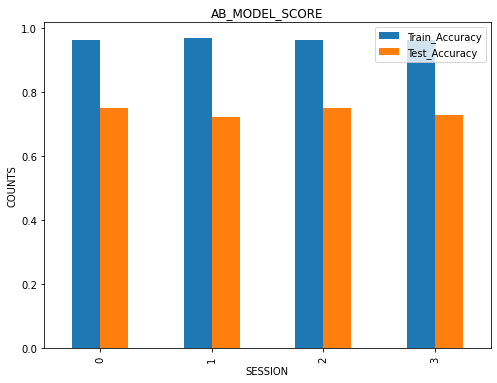

In [60]:
# Using bar-plot for conclusion of the ab_result.
ab_result[['Train_Accuracy','Test_Accuracy']].plot(kind='bar', figsize=(8,6))
plt.xlabel('SESSION')
plt.ylabel('COUNTS')
plt.title('AB_MODEL_SCORE')
plt.legend()
plt.show()

#### Gradient_Boosting_Classifier

In [61]:
# Using GB_Classifier, CountVectorizer and TF-IFD Transformer to build the Model.
gb_model = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', GradientBoostingClassifier(random_state=42, learning_rate=0.01, max_depth=6))])

# Fit the GB_Model
gb_model.fit(X_train, y_train)

# Predicting the GB_Model.
gb_pred_train = gb_model.predict(X_train)
gb_pred_test = gb_model.predict(X_test)

In [62]:
# Evaluating the GB_Model_Training.
# Training_Score.
print('GB_Model Training Score : \n')

gb_model_train_acc = accuracy_score(y_train, gb_pred_train)
print('Accuracy_Score  : {:.3f}'.format(gb_model_train_acc))

gb_model_train_pre = precision_score(y_train, gb_pred_train, average='weighted')
print('Precision_Score : {:.3f}'.format(gb_model_train_pre))

gb_model_train_f1 = f1_score(y_train, gb_pred_train, average='weighted')
print('F1_Score        : {:.3f}'.format(gb_model_train_f1))

gb_model_train_re = recall_score(y_train, gb_pred_train, average='weighted')
print('Recall_Score    : {:.3f}'.format(gb_model_train_re))

GB_Model Training Score : 

Accuracy_Score  : 1.000
Precision_Score : 1.000
F1_Score        : 1.000
Recall_Score    : 1.000


In [63]:
# Evaluating the GB_Model_Testing.
# Testing_Score.
print('GB_Model Testing Score : \n')

gb_model_test_acc = accuracy_score(y_test, gb_pred_test)
print('Accuracy_Score  : {:.3f}'.format(gb_model_test_acc))

gb_model_test_pre = precision_score(y_test, gb_pred_test, average='weighted')
print('Precision_Score : {:.3f}'.format(gb_model_test_pre))

gb_model_test_f1 = f1_score(y_test, gb_pred_test, average='weighted')
print('F1_Score        : {:.3f}'.format(gb_model_test_f1))

gb_model_test_re = recall_score(y_test, gb_pred_test, average='weighted')
print('Recall_Score    : {:.3f}'.format(gb_model_test_re))

GB_Model Testing Score : 

Accuracy_Score  : 0.750
Precision_Score : 0.752
F1_Score        : 0.731
Recall_Score    : 0.750


In [64]:
# Conclusion of the gb_result.
score = ['Accuracy_Score','Precision_Score','Recall_Score','F1_Score']
train = [gb_model_train_acc, gb_model_train_pre, gb_model_train_re, gb_model_train_f1]
test = [gb_model_test_acc, gb_model_test_pre, gb_model_test_re, gb_model_test_f1]

gb_result = pd.DataFrame({'GB_Model_Score':score,'Train_Accuracy':train,'Test_Accuracy':test}).round(3)
gb_result.reindex()

,GB_Model_Score,Train_Accuracy,Test_Accuracy
0,Accuracy_Score,1.0,0.750
1,Precision_Score,1.0,0.752
2,Recall_Score,1.0,0.750
3,F1_Score,1.0,0.731


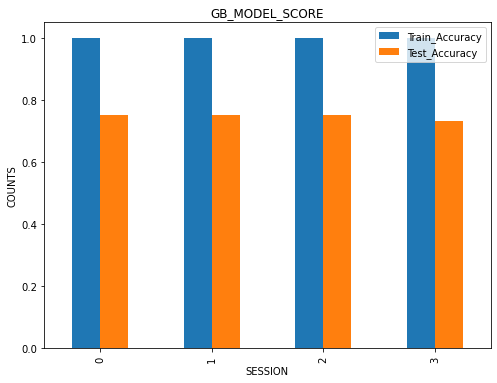

In [65]:
# Using bar-plot for conclusion of the gb_result.
gb_result[['Train_Accuracy','Test_Accuracy']].plot(kind='bar', figsize=(8,6))
plt.xlabel('SESSION')
plt.ylabel('COUNTS')
plt.title('GB_MODEL_SCORE')
plt.legend()
plt.show()

#### Bagging_Classifier

In [66]:
# Using Bagging_Classifier, CountVectorizer and TF-IFD Transformer to build the Model.
bc_model = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', BaggingClassifier(random_state=42, n_estimators=100))])

# Fit the BC_Model
bc_model.fit(X_train, y_train)

# Predicting the BC_Model.
bc_pred_train = bc_model.predict(X_train)
bc_pred_test = bc_model.predict(X_test)

In [67]:
# Evaluating the BC_Model_Training.
# Training_Score.
print('BC_Model Training Score : \n')

bc_model_train_acc = accuracy_score(y_train, bc_pred_train)
print('Accuracy_Score  : {:.3f}'.format(bc_model_train_acc))

bc_model_train_pre = precision_score(y_train, bc_pred_train, average='weighted')
print('Precision_Score : {:.3f}'.format(bc_model_train_pre))

bc_model_train_f1 = f1_score(y_train, bc_pred_train, average='weighted')
print('F1_Score        : {:.3f}'.format(bc_model_train_f1))

bc_model_train_re = recall_score(y_train, bc_pred_train, average='weighted')
print('Recall_Score    : {:.3f}'.format(bc_model_train_re))

BC_Model Training Score : 

Accuracy_Score  : 1.000
Precision_Score : 1.000
F1_Score        : 1.000
Recall_Score    : 1.000


In [68]:
# Evaluating the BC_Model_Testing.
# Testing_Score.
print('BC_Model Testing Score : \n')

bc_model_test_acc = accuracy_score(y_test, bc_pred_test)
print('Accuracy_Score  : {:.3f}'.format(bc_model_test_acc))

bc_model_test_pre = precision_score(y_test, bc_pred_test, average='weighted')
print('Precision_Score : {:.3f}'.format(bc_model_test_pre))

bc_model_test_f1 = f1_score(y_test, bc_pred_test, average='weighted')
print('F1_Score        : {:.3f}'.format(bc_model_test_f1))

bc_model_test_re = recall_score(y_test, bc_pred_test, average='weighted')
print('Recall_Score    : {:.3f}'.format(bc_model_test_re))

BC_Model Testing Score : 

Accuracy_Score  : 0.792
Precision_Score : 0.899
F1_Score        : 0.773
Recall_Score    : 0.792


In [69]:
# Conclusion of the bc_result.
score = ['Accuracy_Score','Precision_Score','Recall_Score','F1_Score']
train = [bc_model_train_acc, bc_model_train_pre, bc_model_train_re, bc_model_train_f1]
test = [bc_model_test_acc, bc_model_test_pre, bc_model_test_re, bc_model_test_f1]

bc_result = pd.DataFrame({'BC_Model_Score':score,'Train_Accuracy':train,'Test_Accuracy':test}).round(3)
bc_result.reindex()

,BC_Model_Score,Train_Accuracy,Test_Accuracy
0,Accuracy_Score,1.0,0.792
1,Precision_Score,1.0,0.899
2,Recall_Score,1.0,0.792
3,F1_Score,1.0,0.773


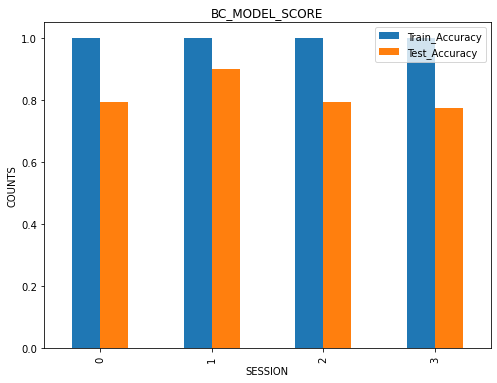

In [70]:
# Using bar-plot for conclusion of the bc_result.
bc_result[['Train_Accuracy','Test_Accuracy']].plot(kind='bar', figsize=(8,6))
plt.xlabel('SESSION')
plt.ylabel('COUNTS')
plt.title('BC_MODEL_SCORE')
plt.legend()
plt.show()

#### Extra_Tree_Classifier

In [71]:
# Using ExtraTree_Classifier, CountVectorizer and TF-IFD Transformer to build the Model.
et_model = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', ExtraTreesClassifier(random_state=42, n_estimators=100))])

# Fit the ET_Model
et_model.fit(X_train, y_train)

# Predicting the ET_Model.
et_pred_train = et_model.predict(X_train)
et_pred_test = et_model.predict(X_test)

In [72]:
# Evaluating the ET_Model_Training.
# Training_Score.
print('ET_Model Training Score : \n')

et_model_train_acc = accuracy_score(y_train, et_pred_train)
print('Accuracy_Score  : {:.3f}'.format(et_model_train_acc))

et_model_train_pre = precision_score(y_train, et_pred_train, average='weighted')
print('Precision_Score : {:.3f}'.format(et_model_train_pre))

et_model_train_f1 = f1_score(y_train, et_pred_train, average='weighted')
print('F1_Score        : {:.3f}'.format(et_model_train_f1))

et_model_train_re = recall_score(y_train, et_pred_train, average='weighted')
print('Recall_Score    : {:.3f}'.format(et_model_train_re))

ET_Model Training Score : 

Accuracy_Score  : 1.000
Precision_Score : 1.000
F1_Score        : 1.000
Recall_Score    : 1.000


In [73]:
# Evaluating the ET_Model_Testing.
# Testing_Score.
print('ET_Model Testing Score : \n')

et_model_test_acc = accuracy_score(y_test, et_pred_test)
print('Accuracy_Score  : {:.3f}'.format(et_model_test_acc))

et_model_test_pre = precision_score(y_test, et_pred_test, average='weighted')
print('Precision_Score : {:.3f}'.format(et_model_test_pre))

et_model_test_f1 = f1_score(y_test, et_pred_test, average='weighted')
print('F1_Score        : {:.3f}'.format(et_model_test_f1))

et_model_test_re = recall_score(y_test, et_pred_test, average='weighted')
print('Recall_Score    : {:.3f}'.format(et_model_test_re))

ET_Model Testing Score : 

Accuracy_Score  : 0.792
Precision_Score : 0.899
F1_Score        : 0.773
Recall_Score    : 0.792


In [74]:
# Conclusion of the et_result.
score = ['Accuracy_Score','Precision_Score','Recall_Score','F1_Score']
train = [et_model_train_acc, et_model_train_pre, et_model_train_re, et_model_train_f1]
test = [et_model_test_acc, et_model_test_pre, et_model_test_re, et_model_test_f1]

et_result = pd.DataFrame({'ET_Model_Score':score,'Train_Accuracy':train,'Test_Accuracy':test}).round(3)
et_result.reindex()

,ET_Model_Score,Train_Accuracy,Test_Accuracy
0,Accuracy_Score,1.0,0.792
1,Precision_Score,1.0,0.899
2,Recall_Score,1.0,0.792
3,F1_Score,1.0,0.773


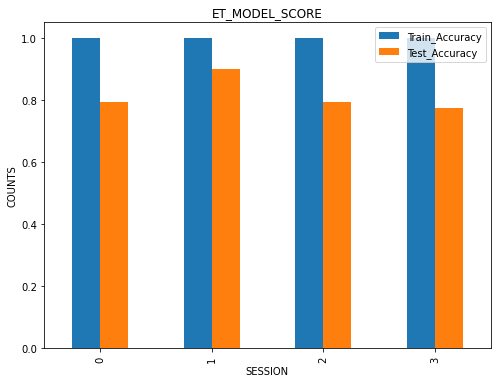

In [75]:
# Using bar-plot for conclusion of the et_result.
et_result[['Train_Accuracy','Test_Accuracy']].plot(kind='bar', figsize=(8,6))
plt.xlabel('SESSION')
plt.ylabel('COUNTS')
plt.title('ET_MODEL_SCORE')
plt.legend()
plt.show()

#### Xtream_Gradient_Boosting_Classifier

In [76]:
# Using XGB_Classifier, CountVectorizer and TF-IDF Transformer to build the Model.
xgb_model = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', XGBClassifier(random_state=42, learning_rate=0.1, max_depth=1, reg_alpha=1))])

# Fit the XGB_Model.
xgb_model.fit(X_train, y_train)

# Predicting the XGB_Model.
xgb_pred_train = xgb_model.predict(X_train)
xgb_pred_test = xgb_model.predict(X_test)

[23:32:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [77]:
# Evaluating the XGB_Model_Training.
# Accuracy_Score.
print('XGB_Model Training Score : \n')

xgb_model_train_acc = accuracy_score(y_train, xgb_pred_train)
print('Accuracy_Score  : {:.3f}'.format(xgb_model_train_acc))

xgb_model_train_pre = precision_score(y_train, xgb_pred_train, average='weighted')
print('Precision_Score : {:.3f}'.format(xgb_model_train_pre))

xgb_model_train_f1 = f1_score(y_train, xgb_pred_train, average='weighted')
print('F1_Score        : {:.3f}'.format(xgb_model_train_f1))

xgb_model_train_re = recall_score(y_train, xgb_pred_train, average='weighted')
print('Recall_Score    : {:.3f}'.format(xgb_model_train_re))

XGB_Model Training Score : 

Accuracy_Score  : 1.000
Precision_Score : 1.000
F1_Score        : 1.000
Recall_Score    : 1.000


In [78]:
# Evaluating the XGB_Model_Testing.
# Accuracy_Score.
print('XGB_Model Testing Score : \n')

xgb_model_test_acc = accuracy_score(y_test, xgb_pred_test)
print('Accuracy_Score  : {:.3f}'.format(xgb_model_test_acc))

xgb_model_test_pre = precision_score(y_test, xgb_pred_test, average='weighted')
print('Precision_Score : {:.3f}'.format(xgb_model_test_pre))

xgb_model_test_f1 = f1_score(y_test, xgb_pred_test, average='weighted')
print('F1_Score        : {:.3f}'.format(xgb_model_test_f1))

xgb_model_test_re = recall_score(y_test, xgb_pred_test, average='weighted')
print('Recall_Score    : {:.3f}'.format(xgb_model_test_re))

XGB_Model Testing Score : 

Accuracy_Score  : 0.750
Precision_Score : 0.785
F1_Score        : 0.747
Recall_Score    : 0.750


In [79]:
# Conclusion of the xgb_result.
score = ['Accuracy_Score','Precision_Score','Recall_Score','F1_Score']
train = [xgb_model_train_acc, xgb_model_train_pre, xgb_model_train_re, xgb_model_train_f1]
test = [xgb_model_test_acc, xgb_model_test_pre, xgb_model_test_re, xgb_model_test_f1]

xgb_result = pd.DataFrame({'XGB_Model_Score':score,'Train_Accuracy':train,'Test_Accuracy':test}).round(3)
xgb_result.reindex()

,XGB_Model_Score,Train_Accuracy,Test_Accuracy
0,Accuracy_Score,1.0,0.750
1,Precision_Score,1.0,0.785
2,Recall_Score,1.0,0.750
3,F1_Score,1.0,0.747


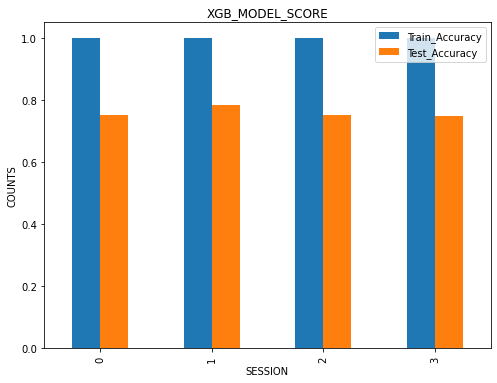

In [80]:
# Using bar-plot for conclusion of the xgb_model_accuracy.
xgb_result[['Train_Accuracy','Test_Accuracy']].plot(kind='bar', figsize=(8,6))
plt.xlabel('SESSION')
plt.ylabel('COUNTS')
plt.title('XGB_MODEL_SCORE')
plt.legend()
plt.show()

#### Support_Vector_Classifier

In [81]:
# Using SVC_Classifier, CountVectorizer and TF-IDF Transformer to build the Model.
svc_model = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SVC(kernel='linear', gamma=0.1))])

# Fit the SVC_Model.
svc_model.fit(X_train, y_train)

# Predicting the SVC_Model.
svc_pred_train = svc_model.predict(X_train)
svc_pred_test = svc_model.predict(X_test)

In [82]:
# Evaluating the SVC_Model_Training.
# Accuracy_Score.
print('SVC_Model Training Score : \n')

svc_model_train_acc = accuracy_score(y_train, svc_pred_train)
print('Accuracy_Score  : {:.3f}'.format(svc_model_train_acc))

svc_model_train_pre = precision_score(y_train, svc_pred_train, average='weighted')
print('Precision_Score : {:.3f}'.format(svc_model_train_pre))

svc_model_train_f1 = f1_score(y_train, svc_pred_train, average='weighted')
print('F1_Score        : {:.3f}'.format(svc_model_train_f1))

svc_model_train_re = recall_score(y_train, svc_pred_train, average='weighted')
print('Recall_Score    : {:.3f}'.format(svc_model_train_re))

SVC_Model Training Score : 

Accuracy_Score  : 0.982
Precision_Score : 0.984
F1_Score        : 0.981
Recall_Score    : 0.982


In [83]:
# Evaluating the SVC_Model_Testing.
# Accuracy_Score.
print('SVC_Model Testing Score : \n')

svc_model_test_acc = accuracy_score(y_test, svc_pred_test)
print('Accuracy_Score  : {:.3f}'.format(svc_model_test_acc))

svc_model_test_pre = precision_score(y_test, svc_pred_test, average='weighted')
print('Precision_Score : {:.3f}'.format(svc_model_test_pre))

svc_model_test_f1 = f1_score(y_test, svc_pred_test, average='weighted')
print('F1_Score        : {:.3f}'.format(svc_model_test_f1))

svc_model_test_re = recall_score(y_test, svc_pred_test, average='weighted')
print('Recall_Score    : {:.3f}'.format(svc_model_test_re))

SVC_Model Testing Score : 

Accuracy_Score  : 0.750
Precision_Score : 0.688
F1_Score        : 0.700
Recall_Score    : 0.750


In [84]:
# Conclusion of the svc_result.
score = ['Accuracy_Score','Precision_Score','Recall_Score','F1_Score']
train = [svc_model_train_acc, svc_model_train_pre, svc_model_train_re, svc_model_train_f1]
test = [svc_model_test_acc, svc_model_test_pre, svc_model_test_re, svc_model_test_f1]

svc_result = pd.DataFrame({'SVC_Model_Score':score,'Train_Accuracy':train,'Test_Accuracy':test}).round(3)
svc_result.reindex()

,SVC_Model_Score,Train_Accuracy,Test_Accuracy
0,Accuracy_Score,0.982,0.750
1,Precision_Score,0.984,0.688
2,Recall_Score,0.982,0.750
3,F1_Score,0.981,0.700


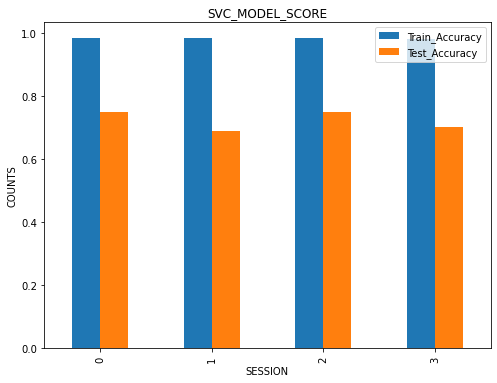

In [85]:
# Using bar-plot for conclusion of the svc_result.
svc_result[['Train_Accuracy','Test_Accuracy']].plot(kind='bar', figsize=(8,6))
plt.xlabel('SESSION')
plt.ylabel('COUNTS')
plt.title('SVC_MODEL_SCORE')
plt.legend()
plt.show()

### Evaluation for all Models Accuracy in the Dataframe

In [86]:
# Creating dataframe for all the Training_Model_Score.
models = ['LR_Model','MultinomialNB','SGD_Model','DT_Model','RF_Model','AB_Model','GB_Model',
          'BC_Model','ET_Model','XGB_Model','SVC_Model']

train_acc = [lr_model_train_acc,mnb_model_train_acc,sgd_model_train_acc,dt_model_train_acc,rf_model_train_acc, 
             ab_model_train_acc,gb_model_train_acc,bc_model_train_acc,et_model_train_acc,xgb_model_train_acc,
             svc_model_train_acc]

train_pre = [lr_model_train_pre,mnb_model_train_pre,sgd_model_train_pre,dt_model_train_pre,rf_model_train_pre,
             ab_model_train_pre,gb_model_train_pre,bc_model_train_pre,et_model_train_pre,xgb_model_train_pre,
             svc_model_train_pre]

train_rec = [lr_model_train_re,mnb_model_train_re,sgd_model_train_re,dt_model_train_re,rf_model_train_re,
             ab_model_train_re,gb_model_train_re,bc_model_train_re,et_model_train_re,xgb_model_train_re,
             svc_model_train_re]

train_f1 = [lr_model_train_f1,mnb_model_train_f1,sgd_model_train_f1,dt_model_train_f1,rf_model_train_f1,
            ab_model_train_f1,gb_model_train_f1,bc_model_train_f1,et_model_train_f1,xgb_model_train_f1,
            svc_model_train_f1]

train_results = pd.DataFrame({'Algorithms':models,
                              'Train_Accuracy_Score':train_acc,
                              'Train_Precision_Score':train_pre,
                              'Train_Recall_Score':train_rec,
                              'Train_F1_Score':train_f1}).sort_values(by=['Train_Accuracy_Score',
                                                                          'Train_Precision_Score',
                                                                          'Train_Recall_Score',
                                                                          'Train_F1_Score'], ascending=True)
train_results.reindex()

,Algorithms,Train_Accuracy_Score,Train_Precision_Score,Train_Recall_Score,Train_F1_Score
1,MultinomialNB,0.854545,0.769587,0.854545,0.802948
5,AB_Model,0.963636,0.970248,0.963636,0.961818
10,SVC_Model,0.981818,0.983636,0.981818,0.981470
0,LR_Model,1.000000,1.000000,1.000000,1.000000
2,SGD_Model,1.000000,1.000000,1.000000,1.000000
3,DT_Model,1.000000,1.000000,1.000000,1.000000
4,RF_Model,1.000000,1.000000,1.000000,1.000000
6,GB_Model,1.000000,1.000000,1.000000,1.000000
7,BC_Model,1.000000,1.000000,1.000000,1.000000
8,ET_Model,1.000000,1.000000,1.000000,1.000000


In [87]:
train_results = pd.melt(train_results, id_vars='Algorithms')

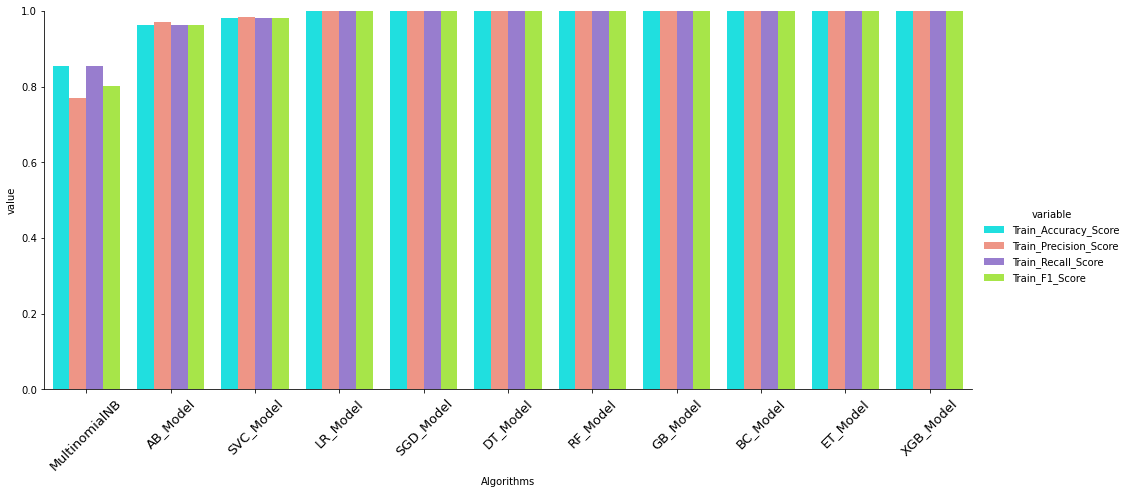

In [88]:
cols = cols = ['cyan','#ff8975', 'mediumpurple','greenyellow'] 
plt = sns.catplot(x = 'Algorithms', y='value', 
                  hue = 'variable',data = train_results, 
                  kind='bar',height=6, palette = cols, aspect=2.3)

plt.set(ylim=(0,1.0))
for axes in plt.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45, size=13)

In [89]:
# Creating dataframe for all the Testing_Model_Score.
models = ['LR_Model','MultinomialNB','SGD_Model','DT_Model','RF_Model','AB_Model','GB_Model',
          'BC_Model','ET_Model','XGB_Model','SVC_Model']

test_acc = [lr_model_test_acc,mnb_model_test_acc,sgd_model_test_acc,dt_model_test_acc,rf_model_test_acc, 
             ab_model_test_acc,gb_model_test_acc,bc_model_test_acc,et_model_test_acc,xgb_model_test_acc,
             svc_model_test_acc]

test_pre = [lr_model_test_pre,mnb_model_test_pre,sgd_model_test_pre,dt_model_test_pre,rf_model_test_pre,
             ab_model_test_pre,gb_model_test_pre,bc_model_test_pre,et_model_test_pre,xgb_model_test_pre,
             svc_model_test_pre]

test_rec = [lr_model_test_re,mnb_model_test_re,sgd_model_test_re,dt_model_test_re,rf_model_test_re,
             ab_model_test_re,gb_model_test_re,bc_model_test_re,et_model_test_re,xgb_model_test_re,
             svc_model_test_re]

test_f1 = [lr_model_test_f1,mnb_model_test_f1,sgd_model_test_f1,dt_model_test_f1,rf_model_test_f1,
            ab_model_test_f1,gb_model_test_f1,bc_model_test_f1,et_model_test_f1,xgb_model_test_f1,
            svc_model_test_f1]

test_results = pd.DataFrame({'Algorithms':models,
                             'Test_Accuracy_Score':test_acc,
                             'Test_Precision_Score':test_pre,
                             'Test_Recall_Score':test_rec,
                             'Test_F1_Score':test_f1}).sort_values(by=['Test_Accuracy_Score',
                                                                        'Test_Precision_Score',
                                                                        'Test_Recall_Score',
                                                                        'Test_F1_Score'], ascending=True)
test_results.reindex()

,Algorithms,Test_Accuracy_Score,Test_Precision_Score,Test_Recall_Score,Test_F1_Score
1,MultinomialNB,0.541667,0.510417,0.541667,0.474747
10,SVC_Model,0.750000,0.687500,0.750000,0.700000
5,AB_Model,0.750000,0.722222,0.750000,0.729167
6,GB_Model,0.750000,0.751786,0.750000,0.730769
9,XGB_Model,0.750000,0.784722,0.750000,0.747024
3,DT_Model,0.791667,0.791667,0.791667,0.787037
0,LR_Model,0.791667,0.822222,0.791667,0.794643
4,RF_Model,0.791667,0.898810,0.791667,0.773148
7,BC_Model,0.791667,0.898810,0.791667,0.773148
8,ET_Model,0.791667,0.898810,0.791667,0.773148


In [90]:
test_results = pd.melt(test_results, id_vars='Algorithms')

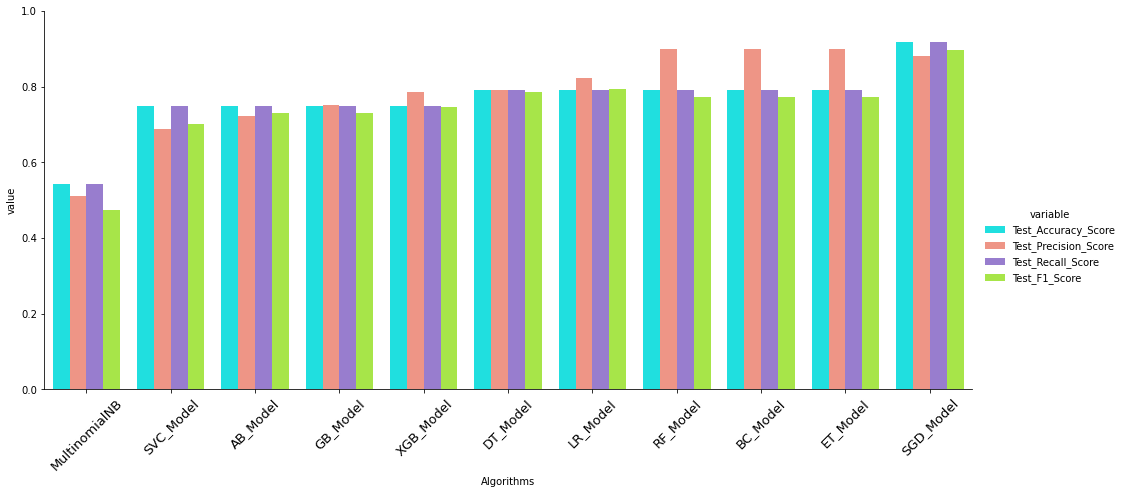

In [91]:
cols = cols= ['cyan','#ff8975', 'mediumpurple','greenyellow'] 
plt = sns.catplot(x = 'Algorithms', y='value', 
                  hue = 'variable', data = test_results, 
                  kind='bar', height=6, palette = cols, aspect=2.3)

plt.set(ylim=(0,1.0))
for axes in plt.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=45, size=13)

#### Best Model is Stochastic_Gradient_Descent_Classifier 

### Model Deployment

In [92]:
# pickling the model
from pickle import dump
dump(sgd_model,open('model.pkl','wb'))

### Conclusion:
  
  #### We have learned the classic problem in NLP, Resumes classification. We learned about important concepts like bag of words, TF-IDF and  important algorithms. We saw that for our data set, both the algorithms were almost equally matched when optimized. Sometimes, if we have enough data set, choice of algorithm can make hardly any difference. So, we can use this code on our data set and see which algorithms works best models.
  
   #### The Best_Model we get Stochastic_Gradient_Descent_Classifier around 91.66% accuracy compared the all other models.

# THE END